In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("HR_comma_sep.csv")
df.columns
X = df.drop(columns=["left"])
y = df['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
X.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [4]:
from sklearn.preprocessing import OneHotEncoder

In [5]:
categorical_features = ["Department", "salary"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
numerical_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numerical_transformer, numerical_features)
    ]
)
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(class_weight='balanced'))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [6]:
pipeline_proba = pipeline.predict_proba(X_test)[:, 1]
pipeline_proba[:]

array([0.06063503, 0.15693716, 0.4455405 , ..., 0.23280593, 0.24901264,
       0.6856552 ])

In [7]:
model = pipeline.named_steps["classifier"]
model.coef_

array([[-1.39355248e-01, -6.14976731e-01,  3.60168996e-02,
         2.87883587e-01, -5.71232019e-01,  9.82552699e-02,
        -2.48009601e-03, -4.03170707e-04,  4.83909430e-02,
         1.52209388e-01, -1.40570531e+00,  5.99454452e-01,
         1.00559680e-01, -1.12113234e+00,  1.96447792e-01,
        -5.14944500e-01,  2.72284933e-01,  6.85813873e-01,
        -5.30735865e-01, -2.16560917e-01]])

In [8]:
ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
ohe_feat = ohe.get_feature_names_out(categorical_features)
nume_feat = numerical_features
feat_names = np.concatenate([ohe_feat, nume_feat])

## удовлетворенность работой и высокая ЗП топ 2 критерия продолжения работы
низкая зп и время в компании же топ 2 критерия увольнения

In [9]:
logreg = pipeline.named_steps["classifier"]
coefs = logreg.coef_[0]

feat_names_coef = zip(feat_names, coefs)
feat_names_coef = sorted(feat_names_coef, key=lambda x: x[1], reverse=True)
 
for name, coef in feat_names_coef:
    print(f"{name}: {coef:.3f}")

time_spend_company: 0.686
salary_low: 0.599
Department_hr: 0.288
average_montly_hours: 0.272
last_evaluation: 0.196
Department_technical: 0.152
salary_medium: 0.101
Department_marketing: 0.098
Department_support: 0.048
Department_accounting: 0.036
Department_sales: -0.000
Department_product_mng: -0.002
Department_IT: -0.139
promotion_last_5years: -0.217
number_project: -0.515
Work_accident: -0.531
Department_management: -0.571
Department_RandD: -0.615
satisfaction_level: -1.121
salary_high: -1.406


## Берем абсолютные коэффициенты и так поймем какие фичи наиболее значимы, какие наименее

In [10]:
feat_names_coef = zip(feat_names, abs(coefs))
feat_names_coef = sorted(feat_names_coef, key=lambda x: x[1], reverse=True)
print("Top 5 features:", feat_names_coef[:5])
print("Bottom 5 features:", feat_names_coef[-5:])

Top 5 features: [('salary_high', 1.4057053093020966), ('satisfaction_level', 1.1211323397883557), ('time_spend_company', 0.6858138725079986), ('Department_RandD', 0.6149767309761915), ('salary_low', 0.5994544515495996)]
Bottom 5 features: [('Department_marketing', 0.09825526987733528), ('Department_support', 0.048390942963025006), ('Department_accounting', 0.03601689955892596), ('Department_product_mng', 0.0024800960067839256), ('Department_sales', 0.00040317070654880384)]


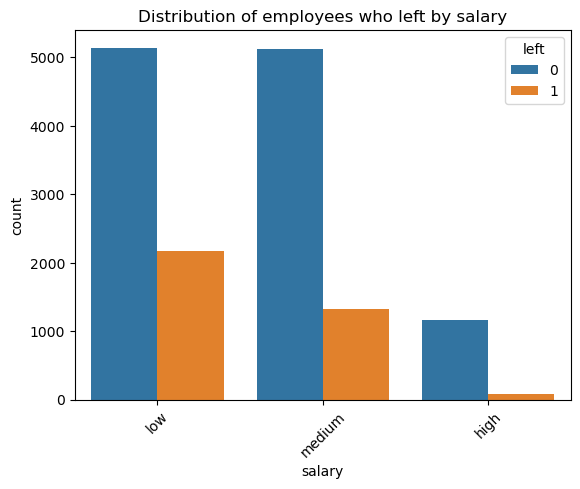

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.countplot(x="salary", hue="left", data=df)
plt.title("Distribution of employees who left by salary")
plt.xticks(rotation=45)
plt.show()

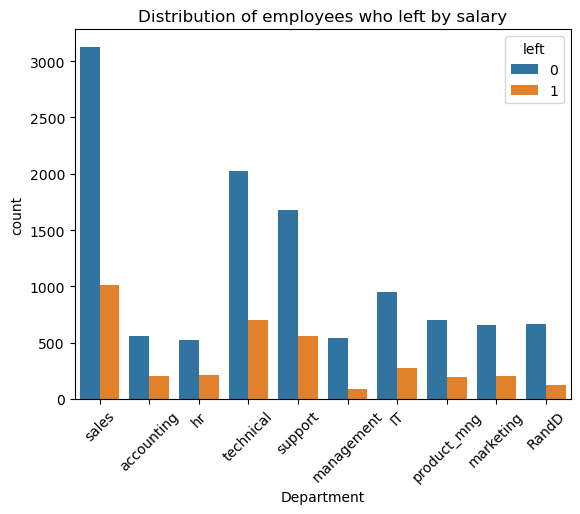

In [12]:
sns.countplot(x="Department", hue="left", data=df)
plt.title("Distribution of employees who left by salary")
plt.xticks(rotation=45)
plt.show()

In [13]:
df['left'].value_counts()

left
0    11428
1     3571
Name: count, dtype: int64

## Модель ловит 80% случаев тех, кто действительно уволился(recall 1)

In [14]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      2294
           1       0.50      0.80      0.62       706

    accuracy                           0.76      3000
   macro avg       0.71      0.78      0.72      3000
weighted avg       0.83      0.76      0.78      3000

